In [1]:
# reproducable randomness
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

c:\users\ck\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### PyPi Modules

In [3]:
import tensorflow as tf
import numpy as np
from keras import backend as K

Using TensorFlow backend.


#### Local Modules

In [4]:
from neural_stylization.vgg19 import VGG_19
from neural_stylization._img_util import load_image, image_to_matrix, normalize, denormalize, matrix_to_image
from keras import backend as K

# Loading Image

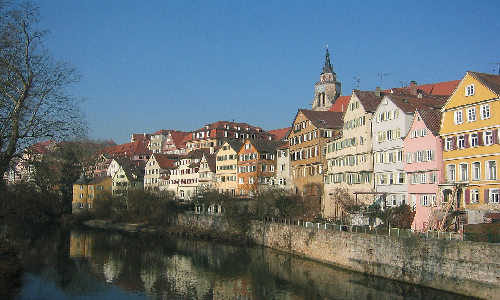

In [5]:
tubingen = load_image('img/content/tubingen.jpg', (500, 300))
tubingen

## Binary Image $\to$ 4D Tensor 

To process the image by the VGG model, we need it in a 4 dimensional
tensor of the shape schema $[frame, height, width, channel]$.

*   $frame$ indexes one of several frames passing through the network
*   $channel$ indexes the _color channel_.
    *   RGB $\implies$ 3
    *   Black and White $\implies$ 1

In [6]:
# convert the binary image data to a Numpy matrix
img = image_to_matrix(tubingen)
img.shape

(1, 300, 500, 3)

In [7]:
# calculate the mean value for each channel
means = img[0].mean(axis=0).mean(axis=0)
means

array([103.283264, 115.21149 , 120.40684 ], dtype=float32)

In [8]:
# normalize the image by the means in the ImageNet data
img = normalize(img)
norm_means = img[0].mean(axis=0).mean(axis=0)
norm_means

array([ 16.467709 ,  -1.5675138, -20.396757 ], dtype=float32)

In [9]:
# invert the means from RGB to BGR using the [::-1] 
# then subtract from the normalized means. This should
# produce the ImageNet means: [103.939, 116.779, 123.68]
means[::-1] - norm_means

array([103.93913, 116.779  , 123.68002], dtype=float32)

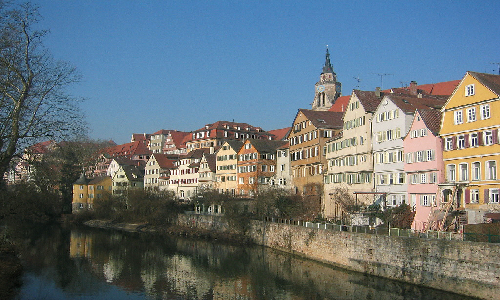

In [10]:
# validate the work by converting back to the Original
# image with no changes made
matrix_to_image(denormalize(img[0]))

# Model Construction

In [11]:
# create a Keras tensor of the image to use as input
# to the VGG19 model
tensor = K.variable(img)

In [12]:
model = VGG_19(include_top=False, input_tensor=tensor)
model

VGG_19(include_top=False, input_tensor=<tf.Variable 'Variable:0' shape=(1, 300, 500, 3) dtype=float32_ref>, pooling=max)

In [13]:
model.outputs

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(1, 300, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(1, 300, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(1, 150, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(1, 150, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(1, 150, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(1, 75, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(1, 75, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(1, 75, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(1, 75, 125, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(1, 75, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(1, 37, 62, 256) dtype=float32>,
 'bloc

## Tensorflow

In [14]:
sess = tf.Session()

http://zachmoshe.com/2017/11/11/use-keras-models-with-tf.html

In [15]:
with sess.as_default():
    tf.global_variables_initializer().run()
    tensor = K.variable(img)
    model = VGG_19(include_top=False, input_tensor=tensor)
    layer = model.get_layer('block1_conv1').output.eval()

In [16]:
layer.shape

(1, 300, 500, 64)

In [17]:
layer[0, :, :, :3].shape

(300, 500, 3)

TODO: visualize some frames in this filter in plain black and white

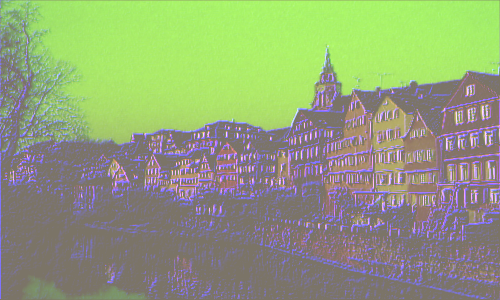

In [18]:
matrix_to_image(denormalize(layer[0, :, :, :3]))

## White Noise

### Uniform White Noise

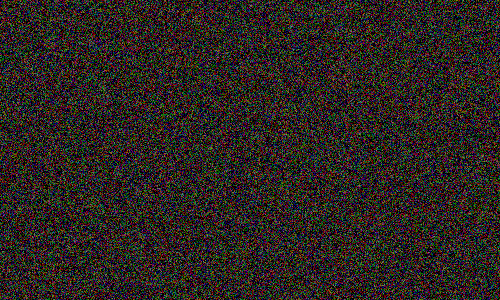

In [19]:
noise = normalize(np.random.uniform(0, 255, (1, 300, 500, 3)))
matrix_to_image(noise.reshape((300, 500, 3)))

### Normal White Noise

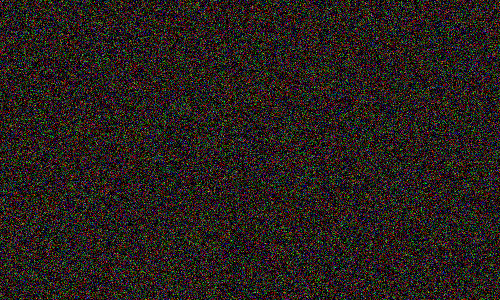

In [20]:
white_noise = normalize(np.random.normal(128, 64, (1, 300, 500, 3)))
matrix_to_image(white_noise.reshape((300, 500, 3)))

In [22]:
# def content_gradient(content, combination):
#     """
#     """
#     return K.maximum(content - combination, 0)

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://github.com/keras-team/keras/blob/master/examples/deep_dream.py

https://keras.io/backend/

In [ ]:
def content_loss(content, combination):
    """
    Return the content loss between the content and combinations tensors.

    Args:
        content: the original content tensor to measure loss from
        combination: the combination image to reduce the loss of

    Returns: the scalar loss between `content` and `combination`
    """
    # squared euclidean distance, exactly how it is in the paper
    return 0.5 * K.sum(K.square(combination - content))

In [27]:
sess = tf.Session()

with sess.as_default():
    # load the content image into keras as a constant, it never changes
    content = K.constant(img, name='Content')
    # create a placeholder for the trained image, this variable trains
    noise = K.placeholder(img.shape, name='Noise')
    # combine the content and canvas tensors along the frame axis (0) 
    # into a 4D tensor of shape [2, height, width, channels]
    tensor = K.concatenate([content, noise], axis=0)
    # build the model with the 4D input tensor of content and canvas
    model = VGG_19(include_top=False, input_tensor=tensor)
    # extract the layer's out that we have interest in for reconstruction
    layer = model.get_layer('block1_conv1').output

    # calculate the loss between the output of the layer on the 
    # content (0) and the canvas (1) 
    loss = content_loss(layer[0], layer[1])

    # calculate the gradients of the model inputs with respect to 
    # the loss. i.e. backpropagate the loss through the network 
    # to the input layer
    grads = K.gradients(loss, model.input)[0]

    # generate the iteration function for gradient descent optimization
    # Args:
    #     noise: the input to the noise placeholder in the model
    #         this effectively takes a the white noise image being
    #         optimized and passes it forward and backward through 
    #         the model collecting the loss and gradient along the 
    #         way
    # 
    # Returns:
    #     a tuple of (loss, gradients)
    #     -   loss: the content loss between the content image
    #         and the white noise
    iterate = K.function([noise], [loss, grads])
    print(iterate)
    
    # generate random noise
    out = normalize(np.random.normal(128, 64, (1, 300, 500, 3)))
    
    for i in range(1000):
        loss_i, grads_i = iterate([out])
        print(loss_i)
        out[0, :, :, :] -= grads_i[1] * 1e-4

K.clear_session()

15757066000.0
15694985000.0
15633310000.0
15572039000.0
15511170000.0
15450699000.0
15390614000.0
15330909000.0
15271585000.0
15212641000.0
15154067000.0
15095865000.0
15038034000.0
14980560000.0
14923450000.0
14866695000.0
14810293000.0
14754245000.0
14698541000.0
14643177000.0
14588149000.0
14533456000.0
14479098000.0
14425076000.0
14371381000.0
14318015000.0
14264963000.0
14212224000.0
14159790000.0
14107662000.0
14055846000.0
14004336000.0
13953116000.0
13902184000.0
13851546000.0
13801202000.0
13751141000.0
13701369000.0
13651881000.0
13602670000.0
13553736000.0
13505085000.0
13456714000.0
13408612000.0
13360783000.0
13313212000.0
13265891000.0
13218834000.0
13172039000.0
13125505000.0
13079218000.0
13033184000.0
12987397000.0
12941858000.0
12896558000.0
12851495000.0
12806667000.0
12762067000.0
12717702000.0
12673564000.0
12629658000.0
12585981000.0
12542535000.0
12499306000.0
12456314000.0
12413550000.0
12371005000.0
12328675000.0
12286564000.0
12244671000.0
12202992000.0
121615

3232755500.0
3227803100.0
3222867200.0
3217946600.0
3213043200.0
3208155100.0
3203283500.0
3198426400.0
3193586000.0
3188760800.0
3183951400.0
3179158000.0
3174379800.0
3169617000.0
3164869600.0
3160137700.0
3155420200.0
3150718200.0
3146030800.0
3141358600.0
3136700400.0
3132057300.0
3127428400.0
3122814200.0
3118214400.0
3113629000.0
3109057800.0
3104500700.0
3099958000.0
3095428900.0
3090914000.0
3086413600.0
3081927200.0
3077454300.0
3072995300.0
3068550000.0
3064118300.0
3059700200.0
3055296000.0
3050905600.0
3046528800.0
3042165200.0
3037814800.0
3033477600.0
3029154000.0
3024843300.0
3020545500.0
3016260600.0
3011989500.0
3007731000.0
3003486000.0
2999253500.0
2995033900.0
2990826800.0
2986632400.0
2982451000.0
2978282200.0
2974126300.0
2969983000.0
2965852400.0
2961734000.0
2957628700.0
2953535700.0
2949454800.0
2945386000.0
2941329400.0
2937284400.0
2933252000.0
2929231600.0
2925223700.0
2921227300.0
2917242600.0
2913269800.0
2909308400.0
2905358800.0
2901421300.0
2897495300.0

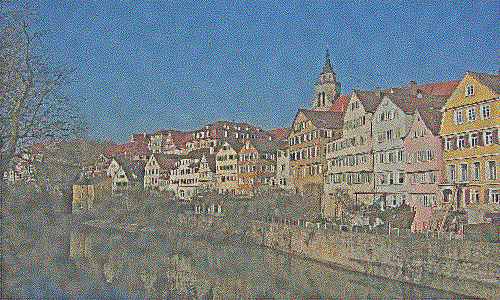

In [28]:
matrix_to_image(denormalize(out[0]))